In [1]:
# Why is this not just a standard feature of every notebook?
%load_ext autoreload
%autoreload 2

In [2]:
from kpl_layers import polynomial
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [3]:
# Count the number of parameters in a model, not getting confused by shared parameters.  Borrowed from Stackoverflow: 
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model/62764464#62764464
def count_parameters(m: torch.nn.Module, only_trainable: bool = False):
    """
    returns the total number of parameters used by `m` (only counting
    shared parameters once); if `only_trainable` is True, then only
    includes parameters with `requires_grad = True`
    """
    parameters = list(m.parameters())
    if only_trainable:
        parameters = [p for p in parameters if p.requires_grad]
    unique = {p.data_ptr(): p for p in parameters}.values()
    return sum(p.numel() for p in unique)

In [4]:
# Let's make a function for setting up the training data
def initialize_datasets(models, input_min, input_max, target_fcn):
    # The minimum number of training examples is ten times the maximum number of weights in the biggest model.
    n_train = 10*max([count_parameters(m,only_trainable=True) for m in models])
    # If let's use at least 100k examples to train, even if we don't need to
    if n_train < 100000:
        n_train = 100000
    # Make n_train a round number
    p10 = 10**math.floor(math.log10(n_train))
    n_train = math.ceil(n_train/p10)*p10
    
    # Create the training dataset
    input_train = (input_max-input_min)*torch.rand(n_train,1)+input_min
    target_train = target_fcn(input_train)
    ds_train = torch.utils.data.TensorDataset(input_train,target_train)
    loader_train = torch.utils.data.DataLoader(ds_train,batch_size=100)

    # Create the testing dataset
    n_test = 1000
    input_test = (input_max-input_min)*torch.rand(n_test,1)+input_min
    target_test = target_fcn(input_test)
    ds_test = torch.utils.data.TensorDataset(input_test,target_test)
    loader_test = torch.utils.data.DataLoader(ds_test,batch_size=100)
    
    return loader_train, loader_test
    

In [5]:
# Taken from the pytorch tutorial code
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Calculate the training loss with 10% of the training data
    stop_at = max(len(dataloader)//10,1)
    train_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            if batch == stop_at:
                break
            pred = model(X)
            train_loss += loss_fn(pred,y).item()
        train_loss/=stop_at

    return train_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [6]:
# Actually run the training
def train(loader_train, loader_test, model, loss, optimizer, max_epochs = 1000):

    loss_data = np.zeros((max_epochs,2), dtype=np.float32)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

    n_no_improvement = 0
    best_loss = 9e20
    for t in range(max_epochs):
        loss_data[t,0] = train_loop(loader_train, model, loss, optimizer)
        loss_data[t,1] = test_loop(loader_test, model, loss)
        scheduler.step(loss_data[t,1])
        if t >= max_epochs*0.1 and best_loss - loss_data[t,1] < 0.001 * best_loss:
            n_no_improvement+=1
        else:
            n_no_improvement = 0
        if np.mean(loss_data[max(0,t-2):t+1,1]) < best_loss:
            best_loss = np.mean(loss_data[max(0,t-2):t+1,1])
        # Stop if we're not improving enough
        if n_no_improvement >=40:
            break
    
    return t+1,loss_data

In [7]:
# Run the training for a range of models and compare the results
def study(models, model_names, target_fcn, x_min, x_max, num_points=200, max_epochs = 1000):

    # Setup the analysis of the trained networks
    x = torch.linspace(x_min,x_max,num_points)
    y_true = target_fcn(x)
    y_pred = torch.zeros(num_points,len(models))

    # Prep for training
    loader_train, loader_test = initialize_datasets(models,x_min,x_max,target_fcn)
    loss = torch.nn.MSELoss()

    n_epoch = []
    loss_vals = []
    duration = []
    for i, model in enumerate(models):
        print(f'Starting training for {model_names[i]}:')
        print(f'{model}')
        # Train the model
        optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
        t_start = time.time()
        n, l = train(loader_train, loader_test, model, loss, optimizer, max_epochs)
        duration.append(time.time()-t_start)
        n_epoch.append(n)
        loss_vals.append(l)
    
        # Check the model
        with torch.no_grad():
            y_pred[:,i] = model(x[:,None])[:,0]
        
        print(f'==> Done in {n} epochs!')

    # Now, let's make the plots
    num_rows = 2
    for model in models:
        if isinstance(model,polynomial.PolySplineLayer):
            num_rows+=1

    fig = plt.figure(figsize=(12.8,num_rows*4.8))
    # Some basic info about the models
    ax = plt.subplot(num_rows,2,1)
    details = ''
    for name, model, n, d in zip(model_names, models, n_epoch, duration):
        n_param = count_parameters(model,only_trainable=True)
        details += f'{name} ({n_param} parameters):\n   Trained for {n} epochs in {d:.0f} seconds\n\n'
    ax.text(0.05,0.5,details,transform=ax.transAxes, fontsize=12, verticalalignment='center')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # The loss curve
    ax = plt.subplot(num_rows,2,2)
    max_ep = max(n_epoch)
    for name, l in zip(model_names, loss_vals):
        ax.plot(l[:max_ep,1],label=name)
    plt.yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend()

    # Plot the output and the true curve
    ax = plt.subplot(num_rows,2,3)
    ax.plot(x,y_pred,label=model_names)
    ax.plot(x[::10],y_true[::10],'ko', label='Target')
    ax.set_ylabel("output")
    ax.set_xlabel("input")
    ax.legend()

    # Plot the residual
    ax = plt.subplot(num_rows,2,4)
    ax.plot(x,y_pred-y_true[:,None],label=model_names)
    ax.set_ylabel("Difference (output-target)")
    ax.set_xlabel("input")
    ax.legend()

    # Now, make special plots for any PolySpineNNs
    iplot = 5
    for name, model in zip(model_names, models):
        if isinstance(model,polynomial.PolySplineLayer):
            with torch.no_grad():
                ax = plt.subplot(num_rows,2,iplot)
                ax.plot(x,model.attention[0](x[:,None]))
                ax.set_ylabel("Attention Output")
                ax.set_xlabel("Input")
                ax.set_title(name)
                ax = plt.subplot(num_rows,2,iplot+1)
                ax.plot(x,model.attention[0](x[:,None])*model.poly_coeffs[0](model.monomial_layer(x[:,None])))
                ax.set_ylabel("Polynomial Output")
                ax.set_xlabel("Input")
                ax.set_title(name)
                iplot+=2

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 348 epochs!
Starting training for PolynomialNN:
PolynomialLayer(
  (monomial_layer): MonomialLayer()
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
==> Done in 369 epochs!
Starting training for PolySplineNN:
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=3, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 578 epochs!


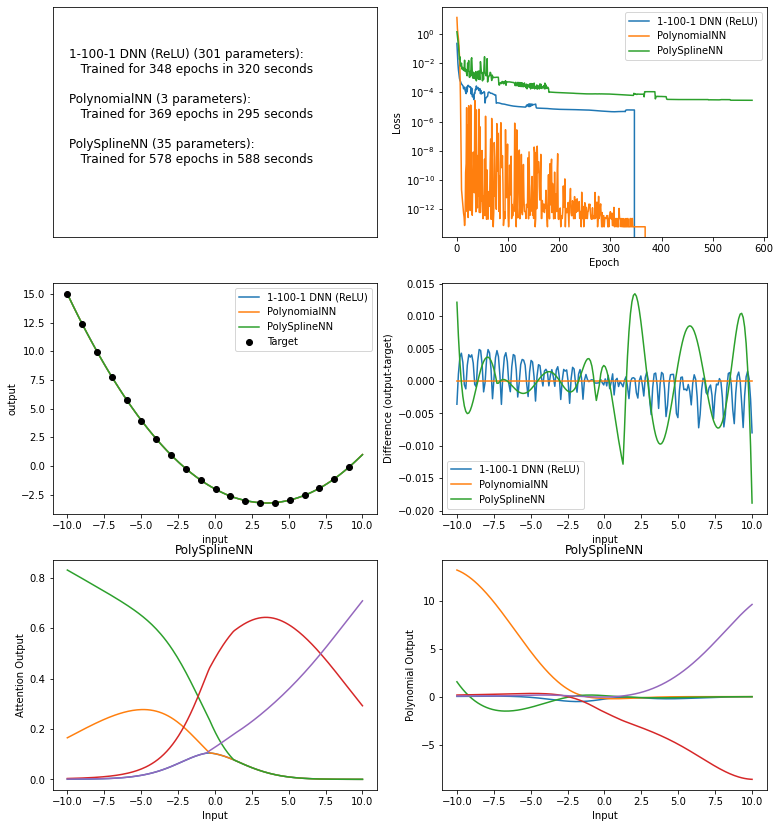

In [8]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolynomialLayer(1,2,1),
    polynomial.PolySplineLayer(1,3,5,1)
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolynomialNN',
    'PolySplineNN'
]

# Our target function
def target_fcn(x):
    return 0.1*x*x - 0.7*x - 2

x_min = -10
x_max = 10

study(models, model_names, target_fcn, x_min, x_max)

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 408 epochs!
Starting training for PolynomialNN:
PolynomialLayer(
  (monomial_layer): MonomialLayer()
  (linear): Linear(in_features=3, out_features=1, bias=True)
)
==> Done in 162 epochs!
Starting training for PolySplineNN:
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 1000 epochs!


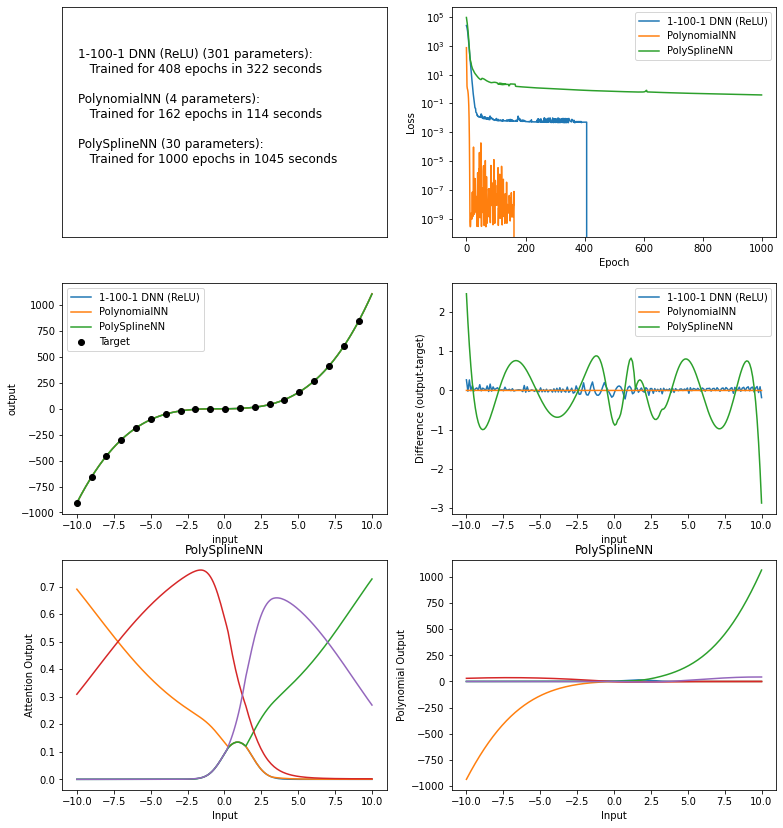

In [9]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolynomialLayer(1,3,1),
    polynomial.PolySplineLayer(1,2,5,1)
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolynomialNN',
    'PolySplineNN'
]

# Our target function
def target_fcn(x):
    return x*x*x + x*x + x + 1

x_min = -10
x_max = 10

study(models, model_names, target_fcn, x_min, x_max)

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 1000 epochs!
Starting training for PolynomialNN:
PolynomialLayer(
  (monomial_layer): MonomialLayer()
  (linear): Linear(in_features=4, out_features=1, bias=True)
)
==> Done in 1000 epochs!
Starting training for PolySplineNN:
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 228 epochs!


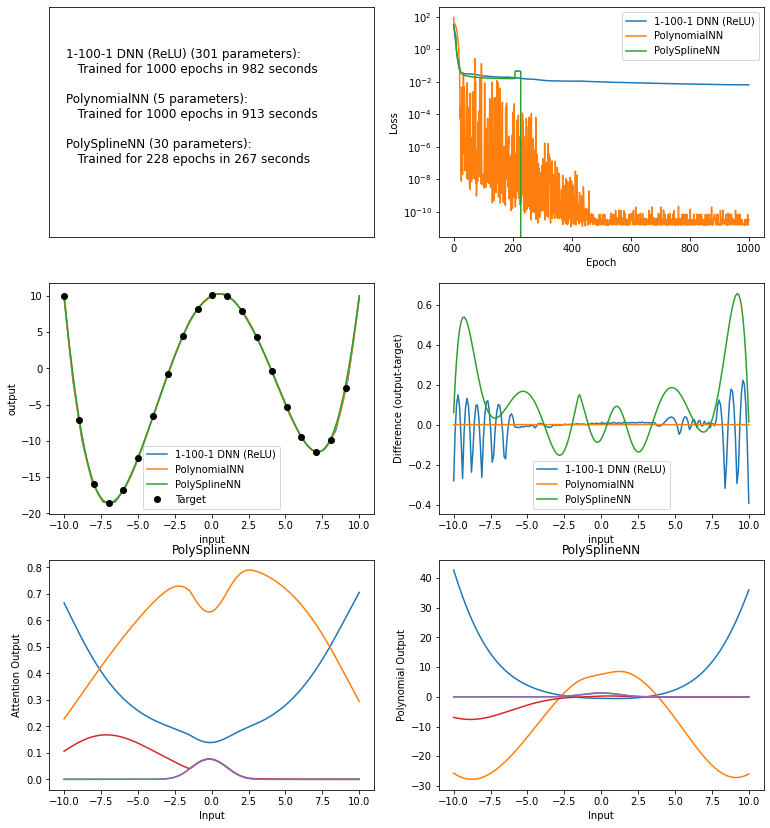

In [10]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolynomialLayer(1,4,1),
    polynomial.PolySplineLayer(1,2,5,1)
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolynomialNN',
    'PolySplineNN'
]

# Our target function
def target_fcn(x):
    return 0.01*x**4 - 0.01*x**3 - x**2 + x + 10

x_min = -10
x_max = 10

study(models, model_names, target_fcn, x_min, x_max)

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 1000 epochs!
Starting training for PolySplineNN:
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=3, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 721 epochs!


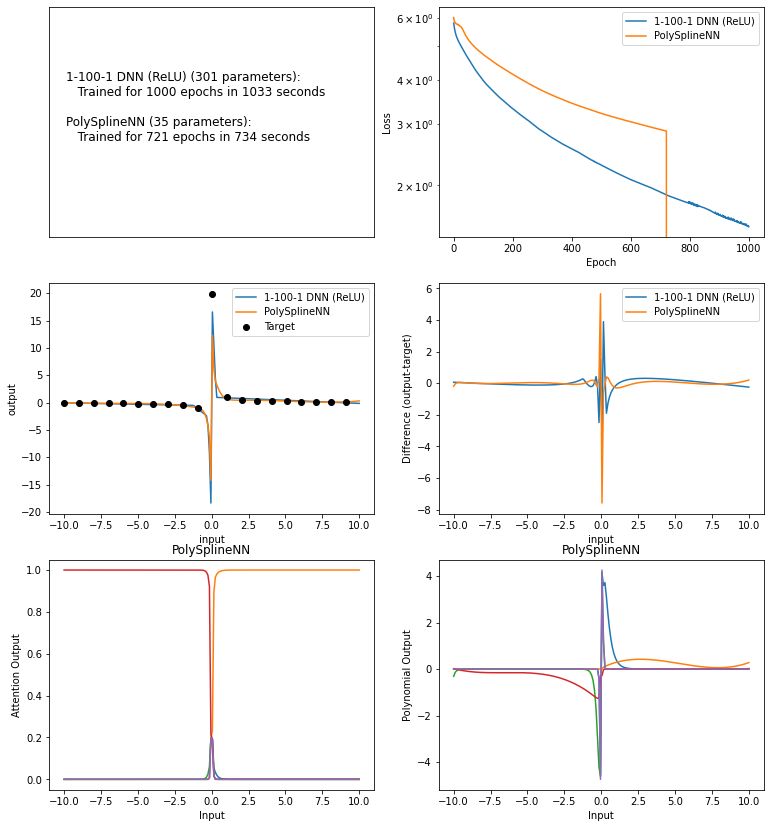

In [11]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolySplineLayer(1,3,5,1)
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolySplineNN'
]

# Our target function - Didn't want to deal with 1/0 error, so made a slight tweak
def target_fcn(x):
    return 1/(x+torch.abs(x)*1e-30/x)

x_min = -10
x_max = 10

study(models, model_names, target_fcn, x_min, x_max)

Starting training for 1-200-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
)
==> Done in 1000 epochs!
Starting training for PolySplineNN(1,2,10,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 193 epochs!
Starting training for PolySplineNN(1,4,10,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_feat

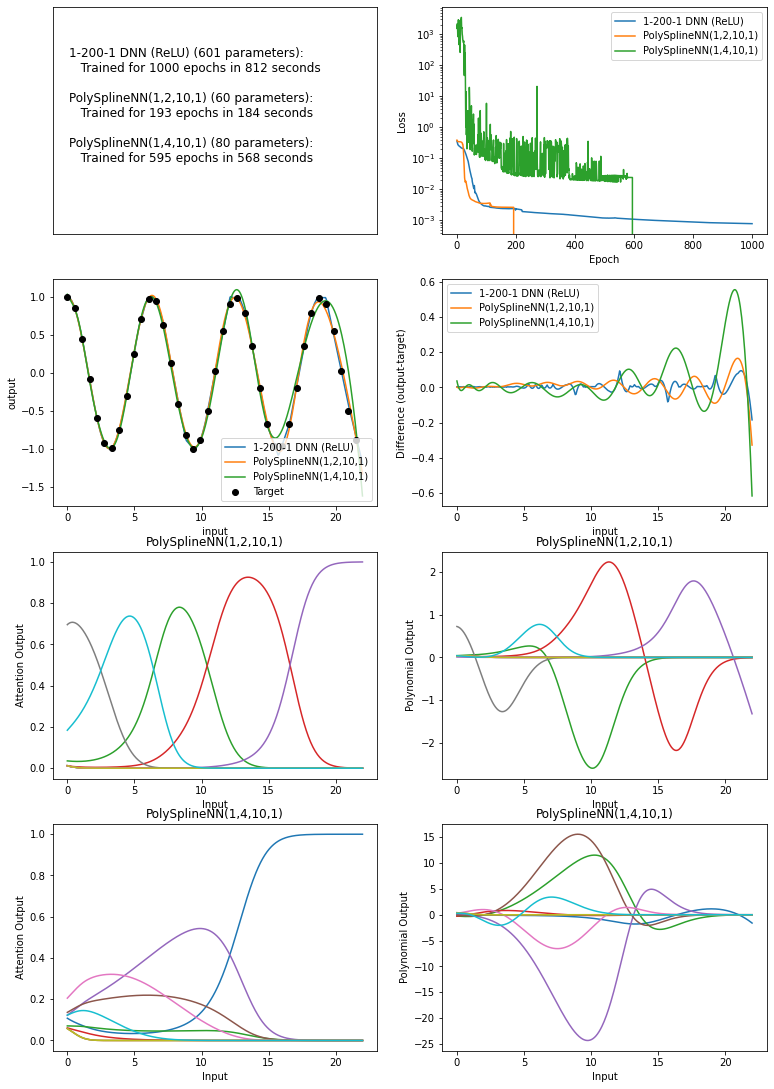

In [12]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,1)
    ),
    polynomial.PolySplineLayer(1,2,10,1),
    polynomial.PolySplineLayer(1,4,10,1)
]

model_names = [
    '1-200-1 DNN (ReLU)',
    'PolySplineNN(1,2,10,1)',
    'PolySplineNN(1,4,10,1)'
]

# Our target function
def target_fcn(x):
    return torch.cos(x)

x_min = 0
x_max = 7*math.pi
num_points = 400

study(models, model_names, target_fcn, x_min, x_max, num_points)

Starting training for 1-200-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
)
==> Done in 203 epochs!
Starting training for PolySplineNN(1,2,10,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 1000 epochs!
Starting training for PolySplineNN(1,4,10,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_feat

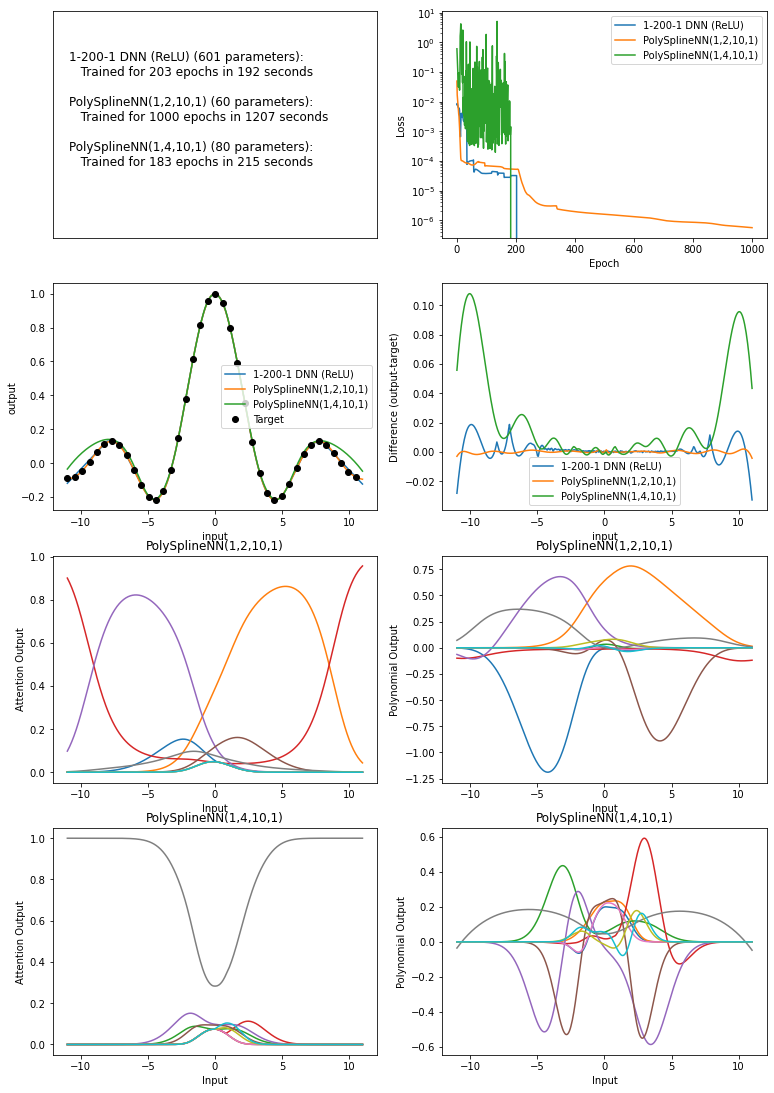

In [13]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,1)
    ),
    polynomial.PolySplineLayer(1,2,10,1),
    polynomial.PolySplineLayer(1,4,10,1)
]

model_names = [
    '1-200-1 DNN (ReLU)',
    'PolySplineNN(1,2,10,1)',
    'PolySplineNN(1,4,10,1)'
]

# Our target function
def target_fcn(x):
    # Want sin(x)/x, but requires special handling at x = 0.
    return torch.where(x==0.,torch.ones_like(x),torch.sin(x)/x)

x_min = -3.5*math.pi
x_max = 3.5*math.pi
num_points = 400

study(models, model_names, target_fcn, x_min, x_max, num_points)

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 558 epochs!
Starting training for PolySplineNN(1,2,5,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 175 epochs!


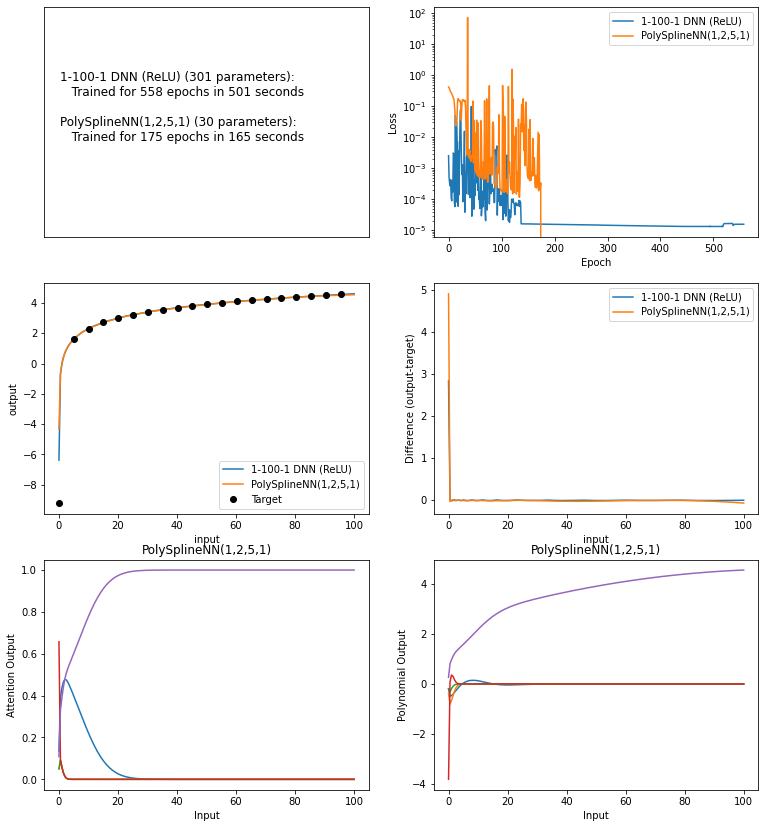

In [14]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolySplineLayer(1,2,5,1),
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolySplineNN(1,2,5,1)'
]

# Our target function
def target_fcn(x):
    return torch.log(x)

x_min = 0.0001
x_max = 100
num_points = 200

study(models, model_names, target_fcn, x_min, x_max, num_points)

Starting training for 1-100-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
==> Done in 176 epochs!
Starting training for PolySplineNN(1,2,5,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=5, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 164 epochs!


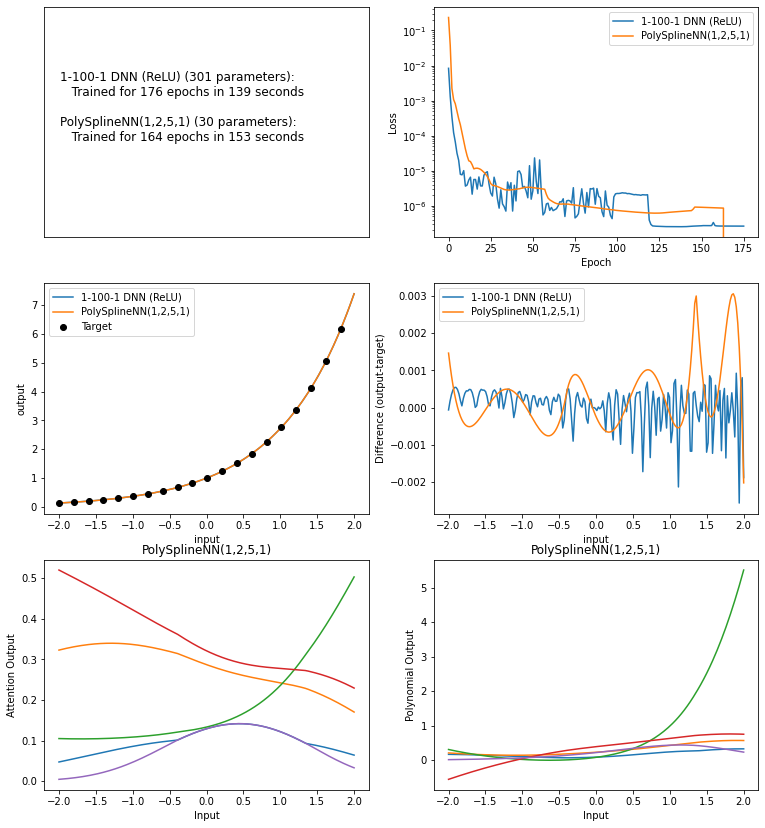

In [15]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    ),
    polynomial.PolySplineLayer(1,2,5,1),
]

model_names = [
    '1-100-1 DNN (ReLU)',
    'PolySplineNN(1,2,5,1)'
]

# Our target function
def target_fcn(x):
    return torch.exp(x)

x_min = -2
x_max = 2
num_points = 200

study(models, model_names, target_fcn, x_min, x_max, num_points)

Starting training for 1-200-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
)
==> Done in 255 epochs!
Starting training for 1-1000-1 DNN (ReLU):
Sequential(
  (0): Linear(in_features=1, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1, bias=True)
)
==> Done in 177 epochs!
Starting training for PolySplineNN(1,2,10,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
  )
  (quadratic_layer): MonomialLayer()
  (attention): ModuleList(
    (0): Sequential(
      (0): MonomialLayer()
      (1): Linear(in_features=2, out_features=10, bias=True)
      (2): ReLU()
      (3): Softmax(dim=-1)
    )
  )
)
==> Done in 349 epochs!
Starting training for PolySplineNN(1,2,20,1):
PolySplineLayer(
  (monomial_layer): MonomialLayer()
  (poly_coeffs): ModuleList(
    

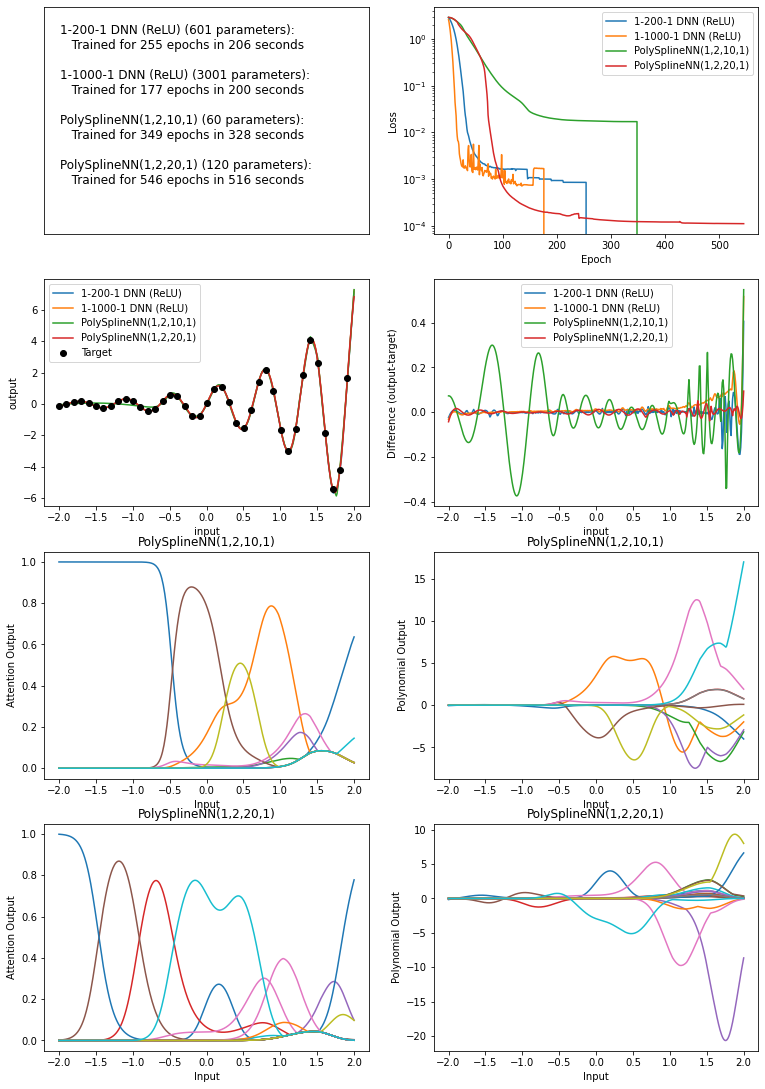

In [16]:
models = [
    torch.nn.Sequential(
        torch.nn.Linear(1,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,1)
    ),
    torch.nn.Sequential(
        torch.nn.Linear(1,1000),
        torch.nn.ReLU(),
        torch.nn.Linear(1000,1)
    ),
    polynomial.PolySplineLayer(1,2,10,1),
    polynomial.PolySplineLayer(1,2,20,1),
]

model_names = [
    '1-200-1 DNN (ReLU)',
    '1-1000-1 DNN (ReLU)',
    'PolySplineNN(1,2,10,1)',
    'PolySplineNN(1,2,20,1)',
]

# Our target function
def target_fcn(x):
    return torch.exp(x)*torch.sin(10*x)

x_min = -2
x_max = 2
num_points = 400

study(models, model_names, target_fcn, x_min, x_max, num_points)